<a href="https://colab.research.google.com/github/nicolevgarduno/seniorCapstone/blob/main/OFFICIAL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import cv2
import imghdr
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [10]:

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU') # all GPUs

# limiting GPUs. keeping to a minimum with these two lines
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[]

In [11]:
# holds path to outr data directory
dataDir = 'data'

In [12]:
imageExt = ['png']

In [13]:
# builds image dataset automatically. builds labels, classes, etc.
data = tf.keras.utils.image_dataset_from_directory('data')

Found 3234 files belonging to 2 classes.


In [14]:
# allows us to access generator from data pipeline. allows us to loop through batches
dataIter = data.as_numpy_iterator()

In [15]:
# shows that we can continously pull batches. basically allows us to grab the batch
dataIter

In [16]:
batch = dataIter.next()

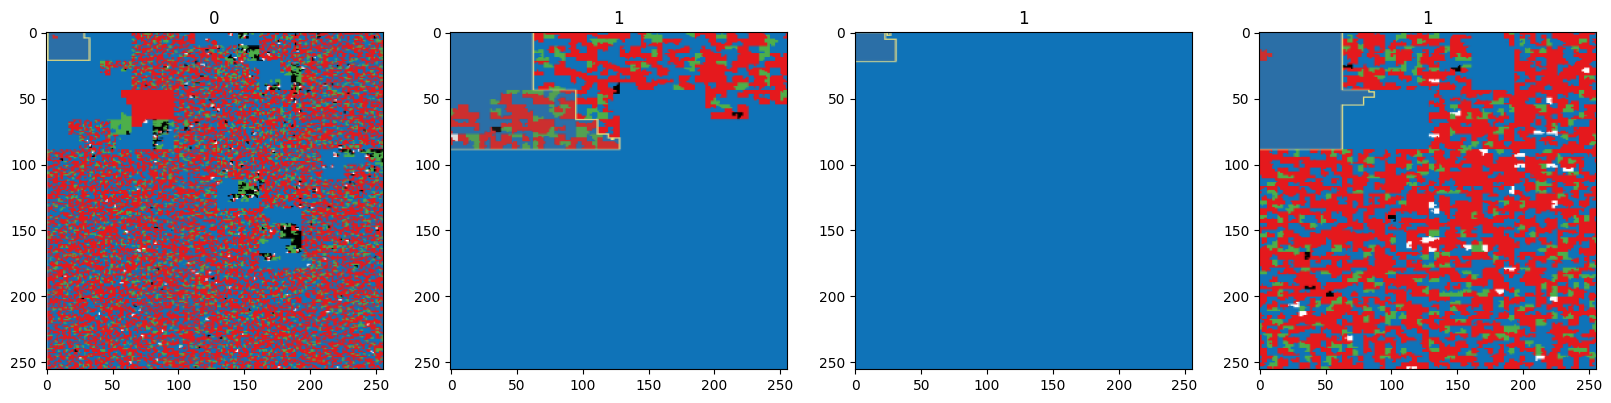

In [17]:
# checking to see how our data was flagged
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
plt.show()

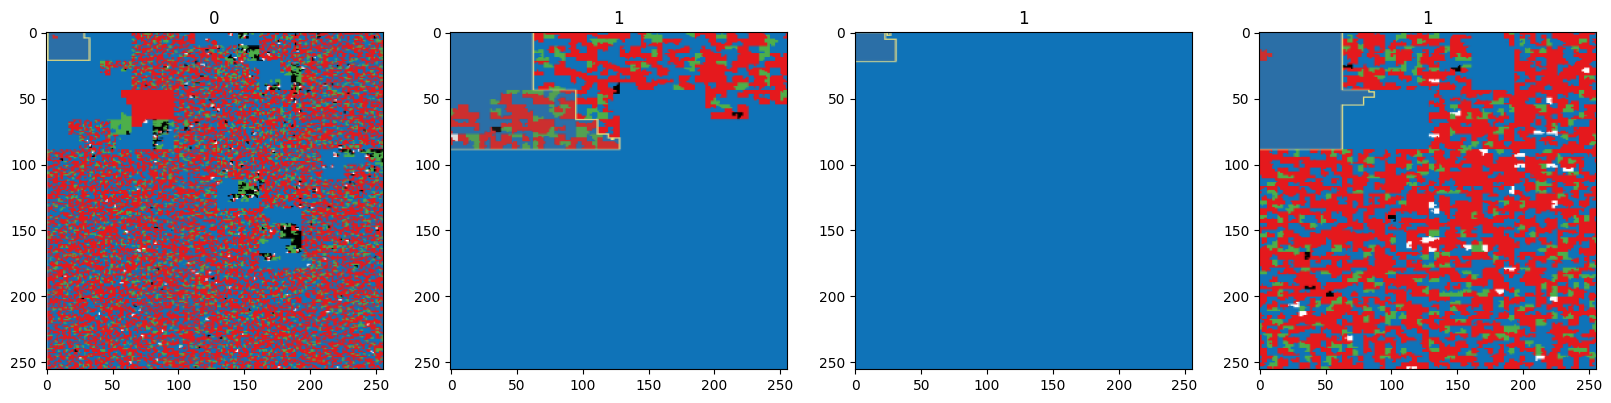

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img_title in enumerate(batch[1][:4]):
    ax[idx].imshow(batch[0][idx].astype(int))
    ax[idx].set_title(img_title)
plt.show()


In [19]:
########DOUBLE CHECK HERE###########

# RGB images are of the values 0 - 255. When building deep learning values,
# we want to use values as small as possible to optimize faster.
# since we're use a data pipeline, we want to make sure data is scaled as
# we load in the data.

# data.map allows performance of transformation within the pipeline.
# lambda allows to go and do transformation
# x is images
# y is target variable
# THIS IS WHAT I COMMENTED data = data.map(lambda x,y: (x/255, y))

In [20]:
# gives access to iterator and grabs our next batch
data.as_numpy_iterator().next()

(array([[[[255.      , 255.      , 255.      ],
          [225.28125 , 220.82812 , 128.82031 ],
          [ 43.      , 111.      , 167.      ],
          ...,
          [ 69.41797 ,  91.83203 , 144.69531 ],
          [229.      ,  25.      ,  29.      ],
          [217.55585 ,  30.33429 ,  35.876556]],
 
         [[255.      , 255.      , 255.      ],
          [225.28125 , 220.82812 , 128.82031 ],
          [ 43.      , 111.      , 167.      ],
          ...,
          [228.3789  ,  25.28125 ,  29.445312],
          [229.      ,  25.      ,  29.      ],
          [229.      ,  25.      ,  29.      ]],
 
         [[255.      , 255.      , 255.      ],
          [225.28125 , 220.82812 , 128.82031 ],
          [ 43.      , 111.      , 167.      ],
          ...,
          [ 15.      , 115.      , 184.      ],
          [ 98.25781 ,  80.24219 , 123.671875],
          [229.      ,  25.      ,  29.      ]],
 
         ...,
 
         [[255.      , 255.      , 255.      ],
          [ 77.   

In [21]:
trainSize = int(len(data)*.7) # what actually trains the model
valSize = int(len(data)*.2) # what evaluates while training
testSize = int(len(data)*.1) + 1 # only used in final evaluation state

In [22]:
# take defines how much data we'll take in partition. we are stating how
# many batches we want to allocate to our training.
train = data.take(trainSize)

# skip batches we've already allocated to training
val = data.skip(trainSize).take(valSize)

# everything leftover
test = data.skip(trainSize+valSize).take(testSize)

In [23]:
model = Sequential()

# adding layers. first layer will be a convolution. and will scan image to make
# an output classification
# 16 is number of filters,(3, 3) size of filters, (1) and stride.
# taking output from Conv2D layer and passing through a function and stating
# that any output below 0 will be converted to 0 and perserve + values.
# allows us to take into account a non-linear patterns
# search up and use a graph from "reul activation", should look like straight
# line near 0 increasing up.
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

# next set we are once again using relu activation
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

#  condensing rows and width and filters will then become the channel value
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# but we want to condense channel value to a singule value, which is why we
# flatter
model.add(Flatten())

# fully connected layers in our neural network
model.add(Dense(256, activation='relu'))
# sigmoid takes any output and converts it into a range between 0 and 1
# AKA both of our classes - malicious or benign
model.add(Dense(1, activation='sigmoid'))

In [24]:
# passing adam optimizer, specifing loss, and we want to pass through accruacy
# to tell us how well our model is classifying
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

First convolution layer converts our original shape of 256 by 256 by 3 and converts it to be 254 by 254 by 16.

Then a max pooling layer converts it into 127 by 127 by 16 (halfing output since 256/2 = 127). Just condesnsing things down as seen by paramaters of max_pooling2d = 0

this repeats until flattening where our layers are multplied and flattened to 14400.

then passing through dense layer and passing to a singular layer.

our deep neural network is now modeled!!

In [26]:
logDir='logs'

In [27]:
# callback is useful to save at certain checkpoints or for specific logging
# logs model training as it trains
tensorboardCallback = tf.keras.callbacks.TensorBoard(log_dir=logDir)

In [29]:
# fit is training component, predict is where we go and make predictions
# epoch is how long we train for, one epoch is on run over out entire training set of data
# after we've trained all our batches, we'll run validation to see how well it
# is being trained.
hist = model.fit(train, epochs=75, validation_data=val, callbacks=[tensorboardCallback])

Epoch 1/75
71/71 [==============================] - 214s 3s/step - loss: 0.1031 - accuracy: 0.9639 - val_loss: 0.2703 - val_accuracy: 0.8828
Epoch 2/75
71/71 [==============================] - 231s 3s/step - loss: 0.0915 - accuracy: 0.9657 - val_loss: 0.1216 - val_accuracy: 0.9563
Epoch 3/75
71/71 [==============================] - 239s 3s/step - loss: 0.0583 - accuracy: 0.9806 - val_loss: 0.1319 - val_accuracy: 0.9563
Epoch 4/75
71/71 [==============================] - 195s 3s/step - loss: 0.0279 - accuracy: 0.9925 - val_loss: 0.1903 - val_accuracy: 0.9531
Epoch 5/75
71/71 [==============================] - 232s 3s/step - loss: 0.0340 - accuracy: 0.9908 - val_loss: 0.1863 - val_accuracy: 0.9609
Epoch 6/75
71/71 [==============================] - 198s 3s/step - loss: 0.0430 - accuracy: 0.9886 - val_loss: 0.6197 - val_accuracy: 0.6609
Epoch 7/75
71/71 [==============================] - 233s 3s/step - loss: 0.6922 - accuracy: 0.5282 - val_loss: 0.6888 - val_accuracy: 0.5578
Epoch 8/75
71

Took about 40 minutes in total to train model.

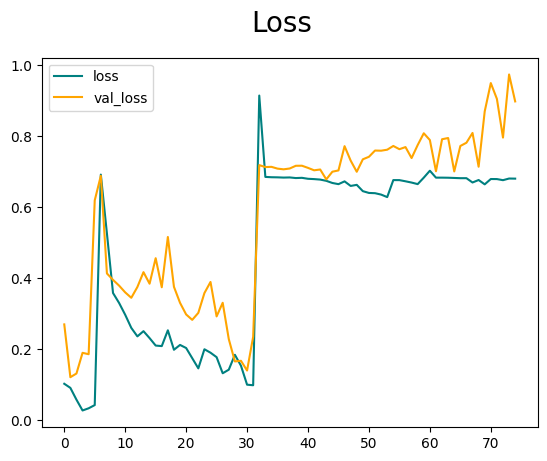

In [30]:
# training loss is teal
# validation loss is orange

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

The gap between the two losses, otherwise known as generalization gap, is minimal. The training loss decreases and begins to reach a point of stability in between x = 0 and x = 2.5 while our validation loss does the same.
The loss curve is typical starts high, indicating the model's predictions are far from the actual values and therefore producing high loss. But as the training continues, the model learns better, makes better predictions, and decreases in loss. The flat curve of the loss curve means the model has almost learn everything it could, so it won't learn much from more training.

i was at first worried with my graph, as most of the time, we see validation lines matching up simarlily with the loss curve, usually a lower starting point. but the generalization gap being so low and become steady so quickly comforted me and i was able to look more deeply into why my validation curve began so low.

my validation loss curve starting so low can indicate that the model performs well not only on the training data we provided, but on unseen validation data. meaning it should generalize well to new and unseen examples!!

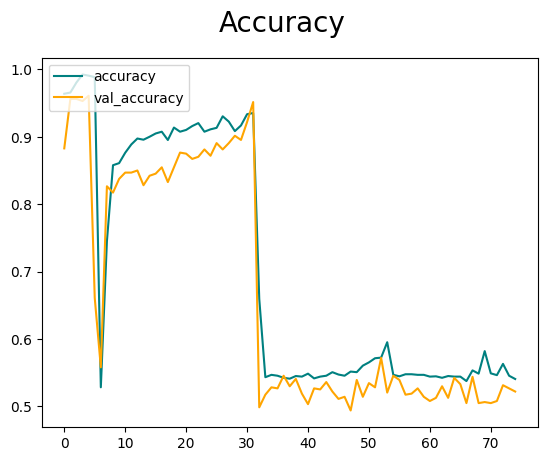

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

It is a good sign that our accuracy does begin to increase, but as we saw in our logs, the accuracy is not 100%. this could be from a number of reasons ranging from the images uploaded, uneven amount of images, or not enough training.

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
# creating instances of the classes
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
# loop through each batch in testing data
for batch in test.as_numpy_iterator():
    # unpack batch
    X, y = batch
    # passing image data through model and making predictions
    yhat = model.predict(X)
    # updating metrics and seeing how it'll perform on test data
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 126ms/step


In [35]:
print(f'Precision:{pre.result().numpy()}, Recall{re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision:0.0, Recall0.0, Accuracy: 0.5403726696968079


### `Tests`




In [38]:
from tensorflow.keras.models import load_model

In [39]:
model.save(os.path.join('models', 'officialTest1.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
# define threshold for classification
threshold = 0.5687

# initialize counters
benignCount = 0
maliciousCount = 0

# path to the folder containing the images
folderPath = "benignTests"

# loop through each file in the folder
for filename in os.listdir(folderPath):
    filePath = os.path.join(folderPath, filename)
    if os.path.isfile(filePath):
        print("Processing file:", filename)

        # load the image
        img = cv2.imread(filePath)

        # resize the image
        img = cv2.resize(img, (256, 256))

        # normalize
        img = img / 255.0

        # predict using the model
        yhat = model.predict(np.expand_dims(img, axis=0))

        # check the prediction
        if yhat > threshold:
            print(f'File {filename} is Malicious. Yhat is {yhat}')
            maliciousCount += 1
        else:
            print(f'File {filename} is Benign. Yhat is {yhat}')
            benignCount += 1

# print counts
total = benignCount + maliciousCount
accuracy = (total / (benignCount/total))
accuracy = accuracy*100
print("Total Benign Files:", benignCount)
print("Total Malicious Files:", maliciousCount)
print("Benign Accuracy: ", (accuracy))


Processing file: alphonso_labs.pdf.png
1/1 [==============================] - 0s 34ms/step
File alphonso_labs.pdf.png is Benign. Yhat is [[0.46321425]]
Processing file: adpholl.pdf.png
1/1 [==============================] - 0s 44ms/step
File adpholl.pdf.png is Benign. Yhat is [[0.46259663]]
Processing file: aod201002.pdf.png
1/1 [==============================] - 0s 36ms/step
File aod201002.pdf.png is Benign. Yhat is [[0.46259663]]
Processing file: appdillo.pdf.png
1/1 [==============================] - 0s 35ms/step
File appdillo.pdf.png is Benign. Yhat is [[0.46259663]]
Processing file: benignTest7.png
1/1 [==============================] - 0s 33ms/step
File benignTest7.png is Benign. Yhat is [[0.46259663]]
Processing file: albc.pdf.png
1/1 [==============================] - 0s 33ms/step
File albc.pdf.png is Benign. Yhat is [[0.46259663]]
Processing file: alamy3.pdf.png
1/1 [==============================] - 0s 37ms/step
File alamy3.pdf.png is Benign. Yhat is [[0.46259663]]
Processing

In [45]:
# define threshold for classification
threshold = 0.5687

# initialize counters
benignCount = 0
maliciousCount = 0

# path to the folder containing the images
folderPath = "benignTests"

# loop through each file in the folder
for filename in os.listdir(folderPath):
    filePath = os.path.join(folderPath, filename)
    if os.path.isfile(filePath):
        print("Processing file:", filename)

        # load the image
        img = cv2.imread(filePath)

        # resize the image
        img = cv2.resize(img, (256, 256))

        # normalize
        img = img / 255.0

        # predict using the model
        yhat = model.predict(np.expand_dims(img, axis=0))

        # check the prediction
        if yhat > threshold:
            print(f'File {filename} is Malicious. Yhat is {yhat}')
            maliciousCount += 1
        else:
            print(f'File {filename} is Benign. Yhat is {yhat}')
            benignCount += 1

# print counts
total = benignCount + maliciousCount
accuracy = (total / (benignCount/total))
accuracy = accuracy*100
print("Total Benign Files:", benignCount)
print("Total Malicious Files:", maliciousCount)

Processing file: alphonso_labs.pdf.png
1/1 [==============================] - 0s 38ms/step
File alphonso_labs.pdf.png is Benign. Yhat is [[0.46321425]]
Processing file: adpholl.pdf.png
1/1 [==============================] - 0s 37ms/step
File adpholl.pdf.png is Benign. Yhat is [[0.46259663]]
Processing file: aod201002.pdf.png
1/1 [==============================] - 0s 39ms/step
File aod201002.pdf.png is Benign. Yhat is [[0.46259663]]
Processing file: appdillo.pdf.png
1/1 [==============================] - 0s 38ms/step
File appdillo.pdf.png is Benign. Yhat is [[0.46259663]]
Processing file: benignTest7.png
1/1 [==============================] - 0s 39ms/step
File benignTest7.png is Benign. Yhat is [[0.46259663]]
Processing file: albc.pdf.png
1/1 [==============================] - 0s 37ms/step
File albc.pdf.png is Benign. Yhat is [[0.46259663]]
Processing file: alamy3.pdf.png
1/1 [==============================] - 0s 37ms/step
File alamy3.pdf.png is Benign. Yhat is [[0.46259663]]
Processing